# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [53]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.linear_model import SGDClassifier
import os

In [2]:
# loading previous cleaned dataset
import sqlite3
con = sqlite3.connect("final.sqlite")

In [3]:
data = pd.read_sql_query("select * from Reviews", con)

In [4]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [6]:
final = data
# Sort data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")
final['Score'] = (final.Score.str.match('positive')).astype(int)
final.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [120]:
#initialing the table
from prettytable import PrettyTable

tableData2 = PrettyTable()
tableData2.field_names = ["Vectorizer", "C", "gamma", "AUC"]
print(tableData2)

+------------+---+-------+-----+
| Vectorizer | C | gamma | AUC |
+------------+---+-------+-----+
+------------+---+-------+-----+


In [33]:
# for linear svm
# 70% of data as Train
xltr = final.CleanedText[0:70000]
yltr = final.Score[0:70000]

# % 30 percent of data as CV
xltest = final.CleanedText[70000:100000]
yltest = final.Score[70000:100000]

# for RBF kernel
xrtr = final.CleanedText[0:14000]
yrtr = final.Score[0:14000]


xrtest = final.CleanedText[14000:20000]
yrtest = final.Score[14000:20000]

print("train linear data shape ",xltr.shape," ",yltr.shape )
print("test linear data shape ",xltest.shape," ",yltest.shape )
print("train rbf data shape ",xrtr.shape," ",yrtr.shape )
print("test rbf data shape ",xrtest.shape," ",yrtest.shape )

train linear data shape  (70000,)   (70000,)
test linear data shape  (30000,)   (30000,)
train rbf data shape  (14000,)   (14000,)
test rbf data shape  (6000,)   (6000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [34]:
# since my ram is only 4gb so i am performing Bag Of Words operation on 100k data only
#BOW
count_vect1 = CountVectorizer(max_features=5000, min_df=10) #in scikit-learn
bowlTrain = count_vect1.fit_transform(xltr.values)
print("the type of count vectorizer ",type(bowlTrain))
print("the shape of out text BOW vectorizer ",bowlTrain.get_shape())
print("the number of unique words ", bowlTrain.get_shape()[1])

bowlTest = count_vect1.transform(xltest.values)
print("the type of count vectorizer ",type(bowlTest))


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 5000)
the number of unique words  5000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


In [109]:
# since my ram is only 4gb so i am performing Bag Of Words operation on 20k data only
#BOW
count_vect2 = CountVectorizer(max_features=500, min_df=10) #in scikit-learn
bowrTrain = count_vect2.fit_transform(xrtr.values)
print("the type of count vectorizer ",type(bowrTrain))
print("the shape of out text BOW vectorizer ",bowrTrain.get_shape())
print("the number of unique words ", bowrTrain.get_shape()[1])

bowrTest = count_vect2.transform(xrtest.values)
print("the type of count vectorizer ",type(bowrTest))


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (14000, 500)
the number of unique words  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


## [4.3] TF-IDF

In [35]:
tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2),max_features=5000,min_df = 10)
tflTr = tf_idf_vect1.fit_transform(xltr.values)
print("the type of count vectorizer ",type(tflTr))
print("the shape of out text tfidf vectorizer ",tflTr.get_shape())


tflTest = tf_idf_vect1.transform(xltest.values)
print("the type of count vectorizer ",type(tflTest))
print("the shape of out text tfidf vectorizer ",tflTest.get_shape())




the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (70000, 5000)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (30000, 5000)


In [110]:
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2),max_features=5000,min_df = 10)

tfrTrain = tf_idf_vect2.fit_transform(xrtr.values)
print("the type of count vectorizer ",type(tfrTrain))
print("the shape of out text BOW vectorizer ",tfrTrain.get_shape())
print("the number of unique words ", tfrTrain.get_shape()[1])

tfrTest = tf_idf_vect2.transform(xrtest.values)
print("the type of count vectorizer ",type(tfrTest))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (14000, 5000)
the number of unique words  5000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


## [4.4] Word2Vec

In [36]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [37]:
#word2vec
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent = []
for sent in xltr.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [38]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 


In [39]:
w2v = w2v_model[w2v_model.wv.vocab]

In [40]:
w2v.shape

(10701, 50)

In [41]:
w2v_model.wv.most_similar('similar')

[('typic', 0.7422674894332886),
 ('ident', 0.6450937390327454),
 ('generic', 0.6442795395851135),
 ('comparison', 0.639157772064209),
 ('compar', 0.6239358186721802),
 ('familiar', 0.6119092106819153),
 ('ordinari', 0.6097143888473511),
 ('convent', 0.5944044589996338),
 ('par', 0.5943674445152283),
 ('unlik', 0.5882119536399841)]

In [111]:
#word2vec
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent = []
for sent in xrtr.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [112]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 


In [113]:
w2v = w2v_model[w2v_model.wv.vocab]

In [114]:
w2v.shape

(5469, 50)

In [115]:
w2v_model.wv.most_similar('similar')

[('except', 0.9082368612289429),
 ('blue', 0.9052467942237854),
 ('typic', 0.9044660329818726),
 ('authent', 0.9040753841400146),
 ('smoki', 0.895815372467041),
 ('consist', 0.8914431929588318),
 ('bittersweet', 0.8906984329223633),
 ('somewhat', 0.8891208171844482),
 ('lighter', 0.8889714479446411),
 ('combin', 0.8886673450469971)]

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [42]:
# average Word2Vec on train data
train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    train.append(sent_vec)
print(len(train))
print(len(train[0]))
# To replace nan with 0 and inf with large finite number

train = np.nan_to_num(train)
trainl1 = train

70000
50


In [43]:
# average Word2Vec on cross validate data
list_of_sent_cv = []
for sent in xltest.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_cv.append(filtered_sentence)
    
# average Word2Vec on train data
cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    cv.append(sent_vec)
print(len(cv))
print(len(cv[0]))
# To replace nan with 0 and inf with large finite number

cv = np.nan_to_num(cv)
testl1 = cv

30000
50


In [116]:
# average Word2Vec on train data
train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    train.append(sent_vec)
print(len(train))
print(len(train[0]))
# To replace nan with 0 and inf with large finite number

train = np.nan_to_num(train)
trainr1 = train

14000
50


In [117]:
# average Word2Vec on cross validate data
list_of_sent_cv = []
for sent in xrtest.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_cv.append(filtered_sentence)
    
# average Word2Vec on train data
cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    cv.append(sent_vec)
print(len(cv))
print(len(cv[0]))
# To replace nan with 0 and inf with large finite number

cv = np.nan_to_num(cv)
testr1 = cv

6000
50


#### [4.4.1.2] TFIDF weighted W2v

In [44]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    train1.append(sent_vec)
    row += 1
    
train1 = np.nan_to_num(train1)
len(train1)
trainl2 = train1
print(trainl2.shape)

(70000, 50)


In [45]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    test1.append(sent_vec)
    row += 1
    
test1 = np.nan_to_num(test1)
len(test1)
testl2 = test1
print(testl2.shape)

(30000, 50)


In [118]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    train1.append(sent_vec)
    row += 1
    
train1 = np.nan_to_num(train1)
len(train1)
trainr2 = train1
print(trainr2.shape)

(14000, 50)


In [119]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    test1.append(sent_vec)
    row += 1
    
test1 = np.nan_to_num(test1)
len(test1)
testr2 = test1
print(testr2.shape)

(6000, 50)


In [46]:
#initialing the table
from prettytable import PrettyTable
tableData1 = PrettyTable()
tableData1.field_names = ["Vectorizer", "penalty", "alpha", "AUC"]
print(tableData1)

+------------+---------+-------+-----+
| Vectorizer | penalty | alpha | AUC |
+------------+---------+-------+-----+
+------------+---------+-------+-----+


In [ ]:
#initialing the table
from prettytable import PrettyTable
tableData1 = PrettyTable()
tableData1.field_names = ["Vectorizer", "penalty", "alpha", "AUC"]
print(tableData1)

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [47]:
from sklearn.model_selection import TimeSeriesSplit
# Please write all the code with proper documentation
tuned_parameters_grid = [{'penalty': ['l1','l2'], 'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
cv = TimeSeriesSplit(n_splits = 3)
model1 = GridSearchCV(SGDClassifier(loss='hinge'), param_grid = tuned_parameters_grid, cv = cv, scoring = "roc_auc")

In [48]:
model1.fit(bowlTrain, yltr)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [49]:
model1.best_estimator_.get_params()['penalty']

'l2'

In [50]:
model1.best_estimator_.alpha

0.01

In [60]:
model1.best_estimator_


SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

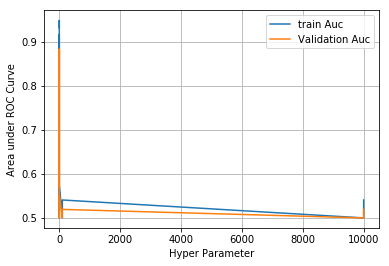

In [51]:
plt.plot(model1.cv_results_['param_alpha'].data,model1.cv_results_['mean_train_score'], label='train Auc')
plt.plot(model1.cv_results_['param_alpha'].data, model1.cv_results_['mean_test_score'], label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


#### Observation
on hyper tuning we get alpha = 0.01 and penalty = l2

In [69]:
lrmodel1 = CalibratedClassifierCV(SGDClassifier(loss='hinge', penalty='l2', alpha = 0.01), method="sigmoid", cv=2)
lrmodel1.fit(bowlTrain, yltr)

tr1 = lrmodel1.predict_proba(bowlTrain)
te1 = lrmodel1.predict_proba(bowlTest)

fpr1, tpr1, thresholds = metrics.roc_curve(yltr, tr1[:,1])
aucltr1 = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds = metrics.roc_curve(yltest, te1[:,1])
aucltest1 = metrics.auc(fpr2, tpr2)

aucltest1
ypred = lrmodel1.predict(bowlTest)

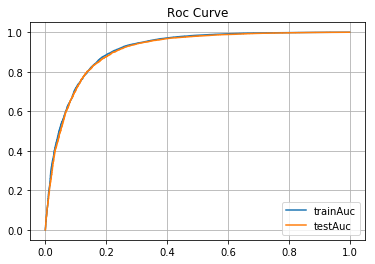

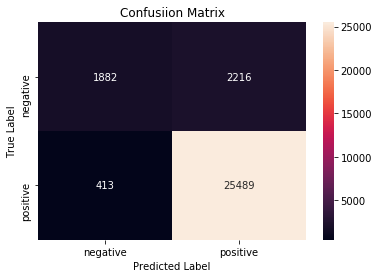

In [70]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yltest, ypred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [71]:
aucltest1

0.9083666062482235

In [76]:
lrmodel11 = SGDClassifier(loss='hinge', penalty='l2', alpha = 0.01)
lrmodel11.fit(bowlTrain, yltr)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [77]:
weights1 = lrmodel11.coef_
weights1.shape

(1, 5000)

In [78]:
bowData = pd.DataFrame({"features":count_vect1.get_feature_names(), "Weights": weights1[0]})
#sorting the weights
features = bowData.sort_values("Weights", ascending = False)

In [79]:
# Top 10 features for +ve reviews are
features.head(10)

,features,Weights
1943,great,0.335114
378,best,0.325400
1166,delici,0.297117
1515,excel,0.284547
2579,love,0.277976
3207,perfect,0.238265
4389,tasti,0.228837
1897,good,0.224552
2938,nice,0.219981
1596,favorit,0.219695


In [80]:
# Top 10 features for -ve reviews are
features.tail(10)

,features,Weights
4480,threw,-0.221409
283,bad,-0.235694
2121,horribl,-0.261406
4918,worst,-0.294260
3648,return,-0.294260
4811,wast,-0.295403
266,aw,-0.297403
4433,terribl,-0.298831
2824,money,-0.302831
1250,disappoint,-0.477387


In [85]:
tableData1.add_row(['BOW', "l2", 0.01, aucltest1])


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [105]:
# Please write all the code with proper documentation
from sklearn.model_selection import TimeSeriesSplit
# Please write all the code with proper documentation
tuned_parameters_grid = [{'penalty': ['l1','l2'], 'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
cv = TimeSeriesSplit(n_splits = 3)
model2 = GridSearchCV(SGDClassifier(loss='hinge'), param_grid = tuned_parameters_grid, cv = cv, scoring = "roc_auc")

In [106]:
model2.fit(tflTr, yltr)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [107]:
model2.best_estimator_.get_params()['penalty']

'l2'

In [108]:
model2.best_estimator_.alpha

0.0001

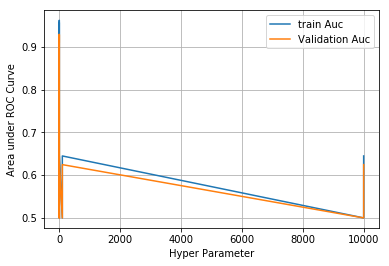

In [109]:
plt.plot(model2.cv_results_['param_alpha'].data,model2.cv_results_['mean_train_score'], label='train Auc')
plt.plot(model2.cv_results_['param_alpha'].data, model2.cv_results_['mean_test_score'], label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


#### Observation
on hyper tuning we get alpha = 0.0001 and penalty = l2

In [87]:
lrmodel2 = CalibratedClassifierCV(SGDClassifier(loss='hinge', penalty='l2', alpha = 0.0001), method="sigmoid", cv=2)
lrmodel2.fit(tflTr, yltr)

tr2 = lrmodel2.predict_proba(tflTr)
te2 = lrmodel2.predict_proba(tflTest)

fpr3, tpr3, thresholds = metrics.roc_curve(yltr, tr2[:,1])
aucltr2 = metrics.auc(fpr3, tpr3)

fpr4, tpr4, thresholds = metrics.roc_curve(yltest, te2[:,1])
aucltest2 = metrics.auc(fpr4, tpr4)

ypred = lrmodel2.predict(tflTest)

aucltest2

0.9450389488494739

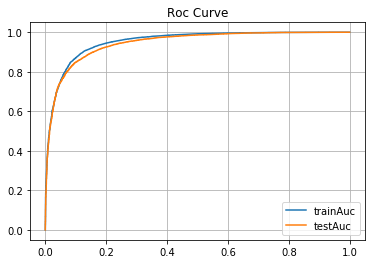

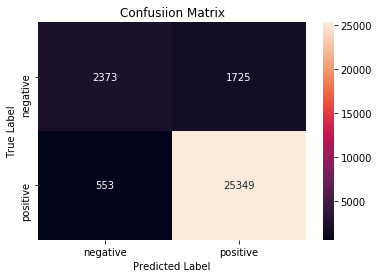

In [88]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr3,tpr3,label="trainAuc")
plt.plot(fpr4,tpr4,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yltest, ypred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [89]:
lrmodel21 = SGDClassifier(loss='hinge', penalty='l2', alpha = 0.0001)
lrmodel21.fit(bowlTrain, yltr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [90]:
weights = lrmodel21.coef_
weights.shape

(1, 5000)

In [91]:
tfData = pd.DataFrame({"features":tf_idf_vect1.get_feature_names(), "Weights": weights[0]})
#sorting the weights
features1 = tfData.sort_values("Weights", ascending = False)

In [92]:
# Top 10 features for +ve reviews are
features1.head(10)

,features,Weights
129,alway keep,1.566956
3961,someon,1.538466
3207,penni,1.538466
1943,grape juic,1.452996
4670,use much,1.339035
1515,fiber,1.339035
1166,dont expect,1.310545
4005,sparkl water,1.253565
3024,offic,1.225075
2115,hfcs,1.196585


In [93]:
# Top 10 features for -ve reviews are
features1.tail(10)

,features,Weights
4480,timothi,-1.509976
4974,yorki,-1.595446
266,bad tast,-1.623936
419,blueberri,-1.652426
2121,high fiber,-1.680916
4386,tell differ,-1.680916
1250,easi prepar,-1.709407
4679,use time,-1.737897
4433,think ill,-1.823367
4918,would expect,-3.162402


In [95]:
tableData1.add_row(['Tf-Idf', "l2", 0.0001, aucltest2])


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [131]:
# Please write all the code with proper documentation
model3 = GridSearchCV(SGDClassifier(loss='hinge'), param_grid = tuned_parameters_grid, cv = 3, scoring = "roc_auc")

In [132]:
model3.fit(trainl1, yltr)

GridSearchCV(cv=3, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [135]:
model3.best_estimator_.get_params()['penalty']

'l2'

In [136]:
model3.best_estimator_.alpha

1

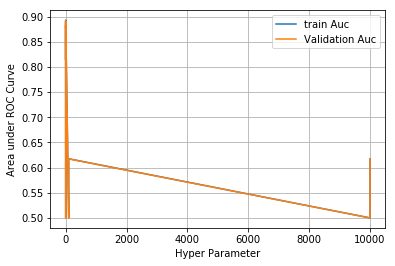

In [137]:
plt.plot(model3.cv_results_['param_alpha'].data,model3.cv_results_['mean_train_score'], label='train Auc')
plt.plot(model3.cv_results_['param_alpha'].data, model3.cv_results_['mean_test_score'], label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


#### Observation
on hyper tuning we get alpha = 1 and penalty = l2

In [96]:
lrmodel3 = CalibratedClassifierCV(SGDClassifier(loss='hinge', penalty='l2', alpha = 1), method="sigmoid", cv=2)
lrmodel3.fit(trainl1, yltr)

tr3 = lrmodel3.predict_proba(trainl1)
te3 = lrmodel3.predict_proba(testl1)

fpr5, tpr5, thresholds = metrics.roc_curve(yltr, tr3[:,1])
aucltr3 = metrics.auc(fpr1, tpr1)

fpr6, tpr6, thresholds = metrics.roc_curve(yltest, te3[:,1])
aucltest3 = metrics.auc(fpr2, tpr2)

ypred = lrmodel3.predict(testl1)
aucltest3

0.9083666062482235

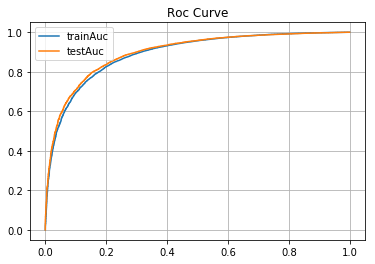

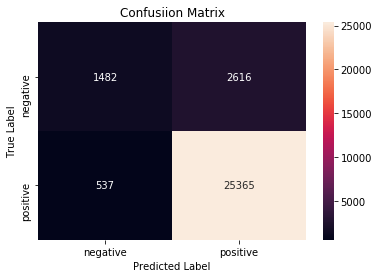

In [97]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr5,tpr5,label="trainAuc")
plt.plot(fpr6,tpr6,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yltest, ypred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



#### Observation
model is completely biased toward +ve side

In [99]:
tableData1.add_row(['AVG W2V', "l2", 1, aucltest3])


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [101]:
# Please write all the code with proper documentation
model4 = GridSearchCV(SGDClassifier(loss='hinge'), param_grid = tuned_parameters_grid, cv = 3, scoring = "roc_auc")

In [102]:
model4.fit(trainl2, yltr)

GridSearchCV(cv=3, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [148]:
model4.best_estimator_.get_params()['penalty']

'l1'

In [149]:
model4.best_estimator_.alpha

0.0001

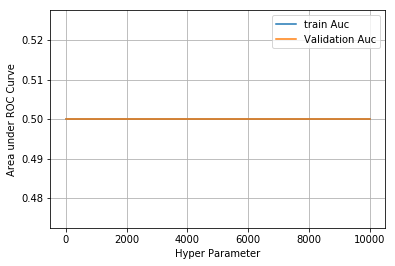

In [150]:
plt.plot(model4.cv_results_['param_alpha'].data,model4.cv_results_['mean_train_score'], label='train Auc')
plt.plot(model4.cv_results_['param_alpha'].data, model4.cv_results_['mean_test_score'], label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


#### Observation
on hyper tuning we get alpha = 0.0001 and penalty = l1

In [104]:
lrmodel4 = CalibratedClassifierCV(SGDClassifier(loss='hinge', penalty='l1', alpha = 0.0001), method="sigmoid", cv=2)
lrmodel4.fit(trainl1, yltr)

tr4 = lrmodel4.predict_proba(trainl2)
te4 = lrmodel4.predict_proba(testl2)

fpr7, tpr7, thresholds = metrics.roc_curve(yltr, tr4[:,1])
aucltr4 = metrics.auc(fpr7, tpr7)

fpr8, tpr8, thresholds = metrics.roc_curve(yltest, te4[:,1])
aucltest4 = metrics.auc(fpr8, tpr8)

ypred = lrmodel4.predict(testl2)

aucltest4

0.5

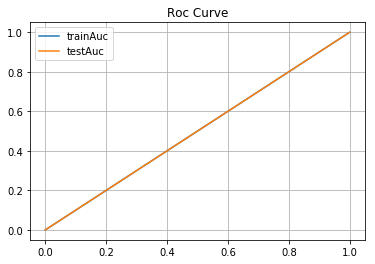

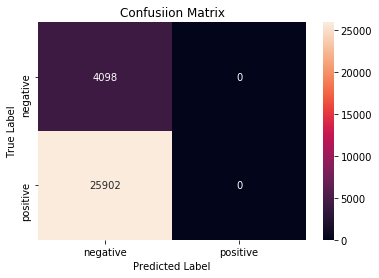

In [105]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr7,tpr7,label="trainAuc")
plt.plot(fpr8,tpr8,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yltest, ypred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



#### Observation
model is completely biased toward -ve side

In [106]:
tableData1.add_row(['Tfidf W2V', "l1", 0.0001, aucltest4])


## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [107]:
from sklearn.svm import SVC

In [165]:
# Please write all the code with proper documentation
param = [{'C': [10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3], 'gamma':[0.01, 0.1, 1, 10]}]
model5 = GridSearchCV(SVC(), param_grid = param,  scoring = "roc_auc")

In [166]:
yrtr.shape

(14000,)

In [167]:
model5.fit(bowrTrain, yrtr)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [171]:
model5.best_estimator_.gamma


0.01

In [172]:
model5.best_estimator_.C


0.1

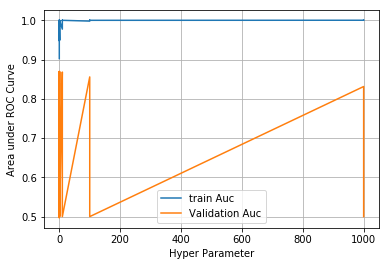

In [177]:
plt.plot(model5.cv_results_['param_C'].data,model5.cv_results_['mean_train_score'], label='train Auc')
plt.plot(model5.cv_results_['param_C'].data, model5.cv_results_['mean_test_score'], label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


#### Observation
on hyper tuning we get C = 0.1 and gamma = 0.01

In [182]:
print(bowrTest.shape)

(6000, 5000)


In [122]:
rmodel1 = SVC(C = 0.1, gamma = 0.01, probability=True)
rmodel1.fit(bowrTrain, yrtr)

tr5 = rmodel1.predict_proba(bowrTrain)
te5 = rmodel1.predict_proba(bowrTest)

fpra, tpra, thresholds = metrics.roc_curve(yrtr, tr5[:,1])
aucltr5 = metrics.auc(fpra, tpra)

fprb, tprb, thresholds = metrics.roc_curve(yrtest, te5[:,1])
aucltest5 = metrics.auc(fprb, tprb)
ypred = rmodel1.predict(bowrTest)


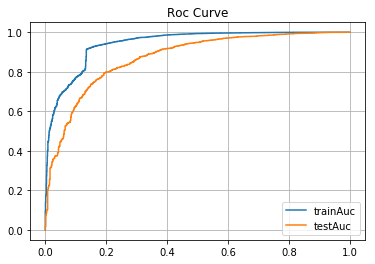

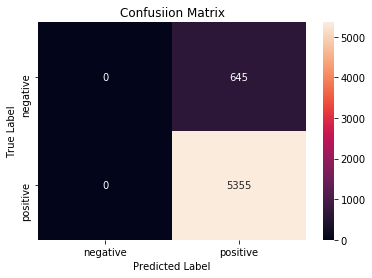

In [124]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpra,tpra,label="trainAuc")
plt.plot(fprb,tprb,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yrtest, ypred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [125]:
print(aucltest5)

0.8716484630027721


In [126]:
tableData2.add_row(['BOW', 0.1, 0.01, aucltest5])


### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [197]:
# Please write all the code with proper documentation
param = [{'C': [10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3], 'gamma':[0.01, 0.1, 1, 10]}]
model6 = GridSearchCV(SVC(), param_grid = param,  scoring = "roc_auc")

In [199]:
model6.fit(tfrTrain, yrtr)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [201]:
model6.best_estimator_.gamma


1

In [202]:
model6.best_estimator_.C


1

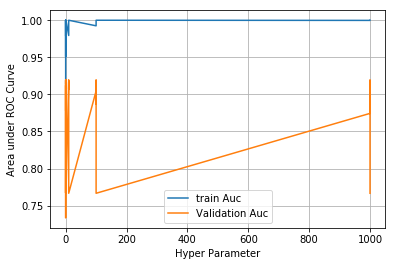

In [203]:
plt.plot(model6.cv_results_['param_C'].data,model6.cv_results_['mean_train_score'], label='train Auc')
plt.plot(model6.cv_results_['param_C'].data, model6.cv_results_['mean_test_score'], label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


#### Observation
on hyper tuning we get C = 0.1 and gamma = 0.01

In [127]:
rmodel2 = SVC(C = 0.1, gamma = 0.01 , probability = True)
rmodel2.fit(tfrTrain, yrtr)

tr6 = rmodel2.predict_proba(tfrTrain)
te6 = rmodel2.predict_proba(tfrTest)

fprc, tprc, thresholds = metrics.roc_curve(yrtr, tr6[:,1])
aucltr6 = metrics.auc(fprc, tprc)


fprd, tprd, thresholds = metrics.roc_curve(yrtest, te6[:,1])
aucltest6 = metrics.auc(fprd, tprd)
ypred = rmodel2.predict(tfrTest)
aucltest6

0.9174192054082615

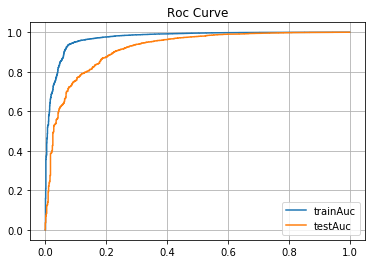

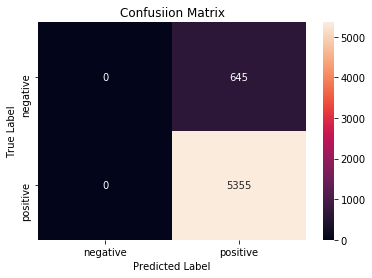

In [128]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fprc,tprc,label="trainAuc")
plt.plot(fprd,tprd,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yrtest, ypred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [129]:
print(aucltest6)

0.9174192054082615


In [130]:
tableData2.add_row(['Tf-Idf', 1, 1, aucltest6])


### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [224]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
param = [{'C': [10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3], 'gamma':[0.01, 0.1, 1, 10]}]
model7 = GridSearchCV(SVC(), param_grid = param,  scoring = "roc_auc")

In [225]:
model7.fit(trainr1, yrtr)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [226]:
model7.best_estimator_.gamma


0.01

In [227]:
model7.best_estimator_.C


10

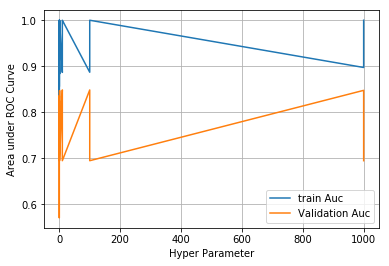

In [228]:
plt.plot(model7.cv_results_['param_C'].data,model7.cv_results_['mean_train_score'], label='train Auc')
plt.plot(model7.cv_results_['param_C'].data, model7.cv_results_['mean_test_score'], label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


In [ ]:
#### Observation
on hyper tuning we get C = 10 and gamma = 0.01

In [131]:
rmodel3 = SVC(C = 10, gamma = 0.01 , probability = True)
rmodel3.fit(trainr1, yrtr)

tr7 = rmodel3.predict_proba(trainr1)
te7 = rmodel3.predict_proba(testr1)

fpre, tpre, thresholds = metrics.roc_curve(yrtr, tr7[:,1])
aucltr7 = metrics.auc(fpre, tpre)

fprf, tprf, thresholds = metrics.roc_curve(yrtest, te7[:,1])
aucltest7 = metrics.auc(fprf, tprf)
ypred = rmodel3.predict(testr1)
aucltest7

0.840381878849731

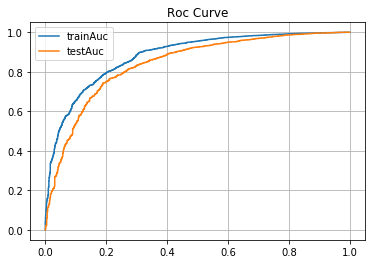

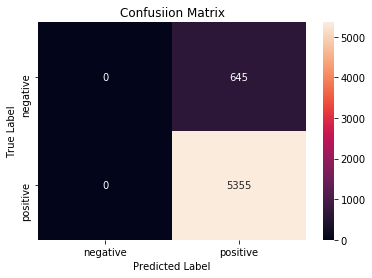

In [132]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpre,tpre,label="trainAuc")
plt.plot(fprf,tprf,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yrtest, ypred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [133]:
print(aucltest7)

0.840381878849731


In [134]:
tableData2.add_row(['AVG-W2V', 10, 0.01, aucltest7])


### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [233]:
# Please write all the code with proper documentation
param = [{'C': [10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3], 'gamma':[0.01, 0.1, 1, 10]}]
model8 = GridSearchCV(SVC(), param_grid = param,  scoring = "roc_auc")

In [234]:
model8.fit(trainr2, yrtr)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [235]:
model8.best_estimator_.gamma


0.01

In [236]:
model8.best_estimator_.C


0.001

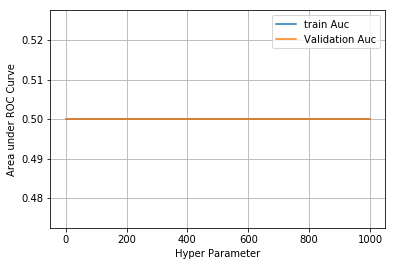

In [237]:
plt.plot(model8.cv_results_['param_C'].data,model8.cv_results_['mean_train_score'], label='train Auc')
plt.plot(model8.cv_results_['param_C'].data, model8.cv_results_['mean_test_score'], label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


#### Observation
on hyper tuning we get C = 0.01 and gamma = 0.01

In [135]:
rmodel4 = SVC(C = 0.01, gamma = 0.01 , probability = True)
rmodel4.fit(trainr2, yrtr)

tr8 = rmodel4.predict_proba(trainr2)
te8 = rmodel4.predict_proba(testr2)

fprg, tprg, thresholds = metrics.roc_curve(yrtr, tr8[:,1])
aucltr8 = metrics.auc(fprg, tprg)

fprh, tprh, thresholds = metrics.roc_curve(yrtest, te8[:,1])
aucltest8 = metrics.auc(fprh, tprh)
ypred = rmodel4.predict(testr2)
aucltest8

0.5

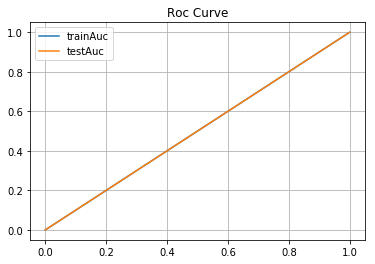

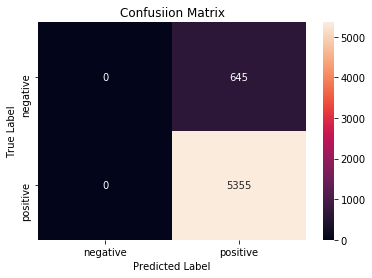

In [136]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fprg,tprg,label="trainAuc")
plt.plot(fprh,tprh,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yrtest, ypred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [137]:
print(aucltest8)

0.5


In [138]:
tableData2.add_row(['TfIdf-W2V', 0.01, 0.01, aucltest8])


# [6] Conclusions

### RBF kernel 
for all vectorizer we get auc score of 0.5

In [139]:
# Please compare all your models using Prettytable library
print(tableData2)

+------------+------+-------+--------------------+
| Vectorizer |  C   | gamma |        AUC         |
+------------+------+-------+--------------------+
|    BOW     | 0.1  |  0.01 | 0.8716484630027721 |
|   Tf-Idf   |  1   |   1   | 0.9174192054082615 |
|  AVG-W2V   |  10  |  0.01 | 0.840381878849731  |
| TfIdf-W2V  | 0.01 |  0.01 |        0.5         |
+------------+------+-------+--------------------+


For Tfidf we get the maximum output

### Linear kernel 
for Bow and Tf-Idf we get auc score of 0.59660
for remaining twovector we get auc of 0.5

In [140]:
print(tableData1)

+------------+---------+--------+--------------------+
| Vectorizer | penalty | alpha  |        AUC         |
+------------+---------+--------+--------------------+
|    BOW     |    l2   |  0.01  | 0.9083666062482235 |
|   Tf-Idf   |    l2   | 0.0001 | 0.9450389488494739 |
|  AVG W2V   |    l2   |   1    | 0.9083666062482235 |
| Tfidf W2V  |    l1   | 0.0001 |        0.5         |
+------------+---------+--------+--------------------+


For TfIdf we get the maximum efficiency